#### PCA + K-means clustering, v4
#### Nov 17, 2020 : data_PMno2_20201030



In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from itertools import chain
from sklearn.cluster import KMeans
root_path='/Users/inkyu/Desktop/KU/Research/Data/PM/raw_data'
import os
from utility_v1 import K_means, PCA_2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
DataFrame = pd.read_excel(root_path + '/data_PMno2_20201030.xlsx')
# DataFrame['PM2_5_median'] = DataFrame['PM2_5_median']-DataFrame['PM1_median']
# DataFrame['PM4_median'] = DataFrame['PM4_median'] - DataFrame['PM2_5_median'] - DataFrame['PM1_median']
# DataFrame['PM10_median'] = DataFrame['PM10_median'] -DataFrame['PM4_median'] - DataFrame['PM2_5_median'] - DataFrame['PM1_median']
# DataFrame['TSP_median'] = DataFrame['TSP_median'] - DataFrame['PM10_median'] -DataFrame['PM4_median'] - DataFrame['PM2_5_median'] - DataFrame['PM1_median']

DataFrame['PM25_mean'] = DataFrame['PM25_mean']-DataFrame['PM1_mean']
DataFrame['PM4_mean'] = DataFrame['PM4_mean'] - DataFrame['PM25_mean'] - DataFrame['PM1_mean']
DataFrame['PM10_mean'] = DataFrame['PM10_mean'] -DataFrame['PM4_mean'] - DataFrame['PM25_mean'] - DataFrame['PM1_mean']
DataFrame['TSP_mean'] = DataFrame['TSP_mean'] - DataFrame['PM10_mean'] -DataFrame['PM4_mean'] - DataFrame['PM25_mean'] - DataFrame['PM1_mean']


#### Extract only baseline data to bl_DF

In [23]:
bl_DF = DataFrame[DataFrame.months==0]
print("Number of Subjects: ", len(bl_DF))
bl_DF = bl_DF.reset_index()
bl_DF = bl_DF.drop(columns=['index'])
bl_DF.head()

Number of Subjects:  225


,no,id,months,fu,dis,filename,subj,PM1_N,PM1_mean,PM1_median,...,PM10_max,TSP_N,TSP_mean,tsp_median,TSP_SD,TSP_min,TSP_max,no2,no2date,no2_name
0,1,PMBR02001,0,NaN,COPD,02-02-001양면모COPD,02-02-001,1554,18.844981,14.6,...,409.2,1554,8.193179,34.1,55.602988,12.9,685.6,20.2,2019.02.12~13,양면모
1,5,PMBR02002,0,NaN,COPD,02-02-002김응수COPD,02-02-002,1567,9.351244,7.7,...,223.3,1567,11.370836,40.0,46.061824,1.7,416.2,31.0,2019.05.06~07,김응수
2,8,PMBR02003,0,NaN,COPD,02-02-003김영길COPD,02-02-003,1686,15.286180,13.2,...,918.0,1686,12.988434,28.8,78.616257,5.8,1043.7,75.0,2019.05.23~24,김영길
3,11,PMBR02004,0,NaN,COPD,02-02-004최종철COPD,02-02-004,1578,10.156971,9.0,...,128.4,1578,2.728327,27.1,21.753609,10.5,234.2,36.2,2019.05.29~30,최종철
4,13,PMBR02005,0,NaN,COPD,02-02-005 곽정위 COPD,02-02-005,1420,10.501831,8.5,...,246.6,1420,18.579437,36.9,75.269321,8.9,1501.1,43.1,2019.10.10~11,곽정위


In [24]:
# For mean only
variables = ["PM1_mean","PM25_mean","PM4_mean","PM10_mean","TSP_mean","no2"]
# For mean and max calculation
# variables = ["PM1_mean","PM25_mean","PM4_mean","PM10_mean","TSP_mean","no2",
#             "PM1_max","PM25_max",'PM4_max','PM10_max','TSP_max']
# For median calculation
# variables = ["PM1_median","PM2_5_median","PM4_median","PM10_median","TSP_median","no2",
#             "PM1_max","PM25_max",'PM4_max','PM10_max','TSP_max']
# Detect Outliers
outliers = []
threshold = 3
for variable in variables:
    z = np.abs(stats.zscore(pd.to_numeric(bl_DF[variable].values)))
    outlier = np.where(z > threshold)
    print("*** Outlier detected ***")
    print(variable)
    for temp in outlier[0].tolist():
        print(bl_DF[variable].iloc[temp])
    
    outliers.extend(outlier)
outliers = np.unique(list(chain(*outliers)))
print("Indices of",len(outliers),"outliers: ", outliers)
# Remove Outliers
for i in range(len(outliers)):
    bl_DF = bl_DF.drop(index=outliers[i])
bl_DF = bl_DF.reset_index()
bl_DF = bl_DF.drop(columns=['index'])   


*** Outlier detected ***
PM1_mean
69.7738206
74.0787969
62.40069156
56.30202939
*** Outlier detected ***
PM25_mean
38.9831894
35.4570578
26.928642859999997
32.46971544
24.161
*** Outlier detected ***
PM4_mean
24.084694759999998
26.84795252
24.007028000000005
26.614730159999993
24.503523040000005
22.717630659999998
29.581384615000005
*** Outlier detected ***
PM10_mean
621.84927264
1787.39375843
*** Outlier detected ***
TSP_mean
561.9989252
142.95774480000003
*** Outlier detected ***
no2
75.0
71.4
65.4
78.9
67.4
Indices of 17 outliers:  [  2  10  12  17  27  31  33  36  48  69  72  74 146 179 182 195 217]


### PCA: 

In [25]:
x = bl_DF.loc[:,variables].values
PCs, weights = PCA_2(x)
PC1 = PCs.iloc[:,0].values
PC2 = PCs.iloc[:,1].values
PC_weights = pd.DataFrame(weights, columns=variables,index=['PC1','PC2'])

Text(0, 0.5, 'PC2')

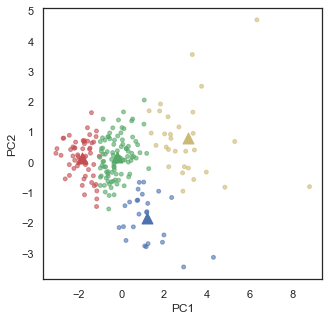

In [39]:
# labels_2, centroids_2 = K_means(PC1, PC2, n=2,plot=True)
# labels_3, centroids_3 = K_means(PC1, PC2, n=3,plot=True)
labels_4, centroids_4 = K_means(PC1, PC2, n=4,plot=True)
plt.xlabel("PC1")
plt.ylabel("PC2")

In [27]:
bl_DF['cluster_n2'] = labels_2
bl_DF['cluster_n3'] = labels_3
bl_DF['cluster_n4'] = labels_4

### Rank each cluster

In [28]:
# Calculate distacne from its centroid
d_n2 =[]
d_n3 =[]
d_n4 =[]
for i in range(len(bl_DF)):
    if bl_DF.loc[i,'cluster_n2'] ==1:
        d_n2.append(np.linalg.norm([np.abs(PC1[i]-centroids_2[0,0]),np.abs(PC2[i]-centroids_2[0,1])]))
        
    elif bl_DF.loc[i,'cluster_n2'] ==2:
        d_n2.append(np.linalg.norm([np.abs(PC1[i]-centroids_2[1,0]),np.abs(PC2[i]-centroids_2[1,1])]))
    
    if bl_DF.loc[i,'cluster_n3'] ==1:
        d_n3.append(np.linalg.norm([np.abs(PC1[i]-centroids_3[0,0]),np.abs(PC2[i]-centroids_3[0,1])]))
    elif bl_DF.loc[i,'cluster_n3'] ==2:
        d_n3.append(np.linalg.norm([np.abs(PC1[i]-centroids_3[1,0]),np.abs(PC2[i]-centroids_3[1,1])]))
    elif bl_DF.loc[i,'cluster_n3'] ==3:
        d_n3.append(np.linalg.norm([np.abs(PC1[i]-centroids_3[2,0]),np.abs(PC2[i]-centroids_3[2,1])]))
        
    if bl_DF.loc[i,'cluster_n4'] ==1:
        d_n4.append(np.linalg.norm([np.abs(PC1[i]-centroids_4[0,0]),np.abs(PC2[i]-centroids_4[0,1])]))
    elif bl_DF.loc[i,'cluster_n4'] ==2:
        d_n4.append(np.linalg.norm([np.abs(PC1[i]-centroids_4[1,0]),np.abs(PC2[i]-centroids_4[1,1])]))
    elif bl_DF.loc[i,'cluster_n4'] ==3:
        d_n4.append(np.linalg.norm([np.abs(PC1[i]-centroids_4[2,0]),np.abs(PC2[i]-centroids_4[2,1])]))
    elif bl_DF.loc[i,'cluster_n4'] ==4:
        d_n4.append(np.linalg.norm([np.abs(PC1[i]-centroids_4[3,0]),np.abs(PC2[i]-centroids_4[3,1])]))
        

In [29]:
bl_DF['d_n2'] = d_n2
bl_DF['d_n3'] = d_n3
bl_DF['d_n4'] = d_n4



In [30]:
def rank_from_dist(df,k,label):
    temp = df[df['cluster_n'+str(k)]==label]
    temp = temp.sort_values(by=['d_n'+str(k)])
    temp = temp.reset_index()
    temp['Rank_n'+str(k)] = temp.index +1
    temp.index = temp.iloc[:,0].values
    temp = temp.drop(columns=['index'])
    return temp

In [31]:
df_k2_1 = rank_from_dist(bl_DF,k=2,label=1)
df_k2_2 = rank_from_dist(bl_DF, k=2, label=2)
df_k2 = pd.concat([df_k2_1,df_k2_2])

df_k3_1 = rank_from_dist(bl_DF,k=3,label=1)
df_k3_2 = rank_from_dist(bl_DF, k=3, label=2)
df_k3_3 = rank_from_dist(bl_DF, k=3, label=3)
df_k3 = pd.concat([df_k3_1,df_k3_2, df_k3_3])

df_k4_1 = rank_from_dist(bl_DF,k=4,label=1)
df_k4_2 = rank_from_dist(bl_DF, k=4, label=2)
df_k4_3 = rank_from_dist(bl_DF, k=4, label=3)
df_k4_4 = rank_from_dist(bl_DF, k=4, label=4)
df_k4 = pd.concat([df_k4_1,df_k4_2, df_k4_3, df_k4_4])

In [32]:
df_k2_3 = pd.merge(df_k2,df_k3, how='outer')
df_k2_3_4 = pd.merge(df_k2_3, df_k4,how='outer')
df_k2_3_4 = df_k2_3_4.sort_values(by=['Rank_n4','cluster_n4'])


In [33]:
df_k2_3_4['PC1'] = PC1
df_k2_3_4['PC2'] = PC2

In [34]:
cols = df_k2_3_4.columns.tolist()
cols = cols[:38] + cols[-2:] + cols[38:-2]
df_k2_3_4 = df_k2_3_4[cols]


In [35]:
with pd.ExcelWriter(os.path.join(root_path,'data_PMno2_200909_mean_clustered_20201030.xlsx')) as writer:
    
    df_k2_3_4.to_excel(writer,index=False)
    PC_weights.to_excel(writer,sheet_name='PC weights')

In [175]:
# with pd.ExcelWriter(os.path.join(root_path,'직독기_202005_07+202004_median_clustered_20201005.xlsx')) as writer:
    
#     bl_DF.to_excel(writer,index=False)
#     PC_weights.to_excel(writer,sheet_name='PC weights')

In [176]:
# DataFrame['clustering_n2'] = -1
# DataFrame['clustering_n3'] = -1
# DataFrame['clustering_n4'] = -1
# Final_DF = DataFrame

# o_index = bl_DF.out_id.values
# r_index = []
# for temp in o_index:
#     r_index.append(int(temp.replace("d",""))-1)
# Final_DF.clustering_n2[r_index] = bl_DF.clustering_n2.values
# Final_DF.clustering_n3[r_index] = bl_DF.clustering_n3.values
# Final_DF.clustering_n4[r_index] = bl_DF.clustering_n4.values
# Ignore the waringing below